In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import sca_osbl_tool as sot
import gsw
from tqdm.auto import tqdm
from sys import platform
from scipy import stats
from constants import nan, kappa, pi
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# interactive figure
%matplotlib widget

In [2]:
year = 2011
floatID = 71
GDrive_root = '/media/zhihua/internal1/GDrive/'
# site_root = GDrive_root + 'UW/Research/Data/OCSP/'
site_root = GDrive_root + 'UW/Research/Data/LakeWA/'
nbf_dir = site_root + 'NBF/'
flux_dir = site_root + 'Mooring/'
# flux_dir = site_root + 'Mooring/'+str(year)+'_high_res/fluxes/'
simfiles = nbf_dir + 'Sim/'+str(floatID)+'/*.nc'
# simfiles = nbf_dir + 'Sim/'+str(year)+'/*.nc'

In [3]:
def select_vars(ds, vars=['zsbl','drift']):
    return ds[vars].squeeze(['lon','lat'], drop=True)

def count_midx(x):
    """
    Count number of times crossing the middle value
    """
    x = sot.butter_lpfilt(x, 1/3600/1.5, 1/30)
    xlow = np.percentile(x, 5)
    xhigh = np.percentile(x, 95)
    xmxmd = x - (xlow + xhigh)/2
    return ((xmxmd[:-1] * xmxmd[1:]) < 0).sum()

def trim_traj(z):
    """
    Trim the float trajectory so it starts and ends at about the same depth,
    by minimizing the fraction of data removed.
    """
    zint = np.around(z)
    nz = len(zint)
    zarray = np.unique(zint) # also sorted
    rm_count = np.full(zarray.shape, nan) # number of points to remove
    for i,m in enumerate(zarray):
        idx1, idx2 = np.where(zint==m)[0][[0, -1]]
        if idx1 != idx2:
            # reverse idx2 to count from the end
            rm_count[i] = idx1 + abs(idx2+1-nz)
    zopt = zarray[np.argmin(rm_count)]
    rmp = np.min(rm_count)/nz
    idx1, idx2 = np.where(zint==zopt)[0][[0, -1]]
    return slice(idx1, idx2+1), rmp

def w_from_drift(z, yd, dt=30):
    """
    Compute vertical velocity from pressure change during a drift
    """
    dts = yd*24*60*(60/dt) # in unit of dt
    # even spacing time array
    yd_even = np.arange(np.ceil(dts[0]), np.floor(dts[-1])+1)/(60/dt)/60/24
    df = pd.DataFrame(np.column_stack((yd, z)), columns=['yd', 'z']).set_index('yd')
    df = df.loc[~df.index.duplicated(), :] # remove duplicated time points
    dfi = df.reindex(df.index.union(yd_even)) \
            .interpolate(method='pchip', limit_direction='both', limit_area='inside').reindex(yd_even)

    # trimmed, rmp = trim_traj(dfi.z)
    # dfi = dfi.iloc[trimmed]
    dfi['w'] = np.convolve(dfi.z, [1, 0, -1], 'same')/(2*dt)
    dfi = dfi.iloc[1:-1,:] # invalid results at both ends
    if dt==1:
        # apply median filter and lowpass filter
        wmedf = dfi.w.rolling(5, min_periods=3, center=True).median()
        dfi['wf'] = sot.butter_lpfilt(wmedf, 0.1/2/pi, 1)
        
        dfi['wf2'] = dfi.wf**2
        dfi['wf2bulk'] = np.full_like(dfi.z, dfi.wf2.mean())

        # layer-averaged dissipation rate from Lagrangian spectrum
        omega,Pww = sot.get_psd(dfi.wf, fs=1/dt)
        Paa = omega**2*Pww
        Pnoise = 0.001 # better moise model?
        Lfloat = 0.92/2
        dfi['epsbulk'] = np.full_like(dfi.z, sot.fit_spec(omega, Paa, Pnoise, Lfloat)[0])

    # max dt in fast pressure drift data is e~ 3s, it's ok to use uniform sampled data 
    # skip the re-interpolation back to original sampling time
    return dfi#, rmp

def bin_w(df, year):
    """
    Bin average vertical velocities in unifom time and z grid
    """
    # df['w2'] = df.w**2
    # df['wf2'] = df.wf**2
    # df['w3'] = df.w**3
    df['wf3'] = df.wf**3
    
    # set bin edges
    time_start, time_end = df.time.iloc[[0, -1]].round('60min')
    hhtime = pd.Timedelta(minutes=30)
    time_bins = pd.date_range(time_start-hhtime, time_end+hhtime, freq='H')
    zbt = np.floor(df.z.min())
    z_bins = np.arange(zbt, 1)
    
    # bin data
    grpd = df.groupby([pd.cut(df.time, time_bins), pd.cut(df.z, z_bins)])
    grpm = grpd.mean()
    grpc = grpd.w.count().replace(0, nan).rename('n')
    bnd = pd.concat([grpm, grpc], axis=1).rename(columns={'z': 'mz'}).reset_index()
    
    # remove empty time intervals between drifts
    myd = bnd.yd.groupby(bnd.time).transform('mean')
    in_drift = myd.notnull()
    bnd = bnd[in_drift].reset_index(drop=True)
    bnd.time = myd[in_drift].reset_index(drop=True).apply(lambda x: sot.yd2pytime(x,year))
    bnd.z = bnd.z.apply(lambda x: x.mid)
    
    # to xarray dataset
    bnd_ds = bnd.set_index(['time', 'z']).to_xarray()
    bnd_ds['yd'] = bnd_ds.yd.mean(dim='z')
    bnd_ds['drift'] = bnd_ds.drift.mean(dim='z')
    bnd_ds['epsbulk'] = bnd_ds.epsbulk.mean(dim='z')
    bnd_ds['wf2bulk'] = bnd_ds.wf2bulk.mean(dim='z')
    return bnd_ds.set_coords('yd')

In [4]:
# original float data
with xr.open_dataset(nbf_dir+'LKWA_env_'+str(floatID)+'.nc') as E:
# with xr.open_dataset(nbf_dir+'OCSP_env_'+str(year)+'.nc') as E:
    drift0 = E.drift.values
    yd = E.yd.values
    ydP = E.ydP.values
    Pc = E.Pc.values
    P = E.P.values
    B = E.B.values
    lat = E.lat.reset_coords('yd', drop=True)
    lon = E.lon.reset_coords('yd', drop=True)
mlat = np.mean(lat.values)
Zc = gsw.z_from_p(Pc, mlat)

# float buoyancy
# with xr.open_dataset(nbf_dir+'OCSP_fb_'+str(year)+'.nc') as Fb:
#     b = Fb.b.values

# KPP BLD
with xr.open_mfdataset(simfiles, combine='by_coords', preprocess=select_vars,
                       data_vars='minimal', coords='minimal', compat='override') as ds:
    time_gotm = pd.date_range(start=ds.time[0].values, end=ds.time[-1].values, freq='5min')
    zsbl = ds.zsbl.interp(time=time_gotm).load()
zsbl = zsbl.assign_coords(yd=('time', sot.pytime2yd(zsbl.time)))
zsbl = xr.apply_ufunc(sot.butter_lpfilt, zsbl, input_core_dims=[['time']],
                      output_core_dims=[['time']], kwargs={'cutoff': 1/60/12, 'fs': 1/5})
bld = -zsbl.resample(time='60min', base=30, loffset=pd.Timedelta(minutes=30)).mean()
bld[bld<1e-2] = 1e-2

# surface forcing
with xr.open_dataset(flux_dir+'LKWA_fluxes.nc') as F:
# with xr.open_dataset(flux_dir+'OCSP_fluxes_'+str(year)+'.nc') as F:
    ustar = F.ustar.squeeze(drop=True).reset_coords('yd', drop=True).interp(time=bld.time)
    wbnet = F.wbnet.squeeze(drop=True).reset_coords('yd', drop=True).interp(time=bld.time)
BFsign = np.sign(wbnet)
wstar = BFsign*( (np.abs(wbnet)*bld)**(1/3) )
wbulk2 = 1.1*(ustar**2) + 0.3*BFsign*(wstar**2)
wbulk2[wbulk2<1e-10] = 1e-10
wbulk = np.sqrt(wbulk2)
LObukhov = -ustar**3/kappa/wbnet

# drift selection
_,Iclump = sot.get_clumps(drift0, min_len=360) # at least 3-hours long, 3*3600/30=360
# index for the beginning of drift: when the rate of change of float buoyancy control B is less than 0.02 cc/s
i_drift_on = [np.where( np.abs(np.gradient(B[I], yd[I]*24*3600)) < 0.02 )[0][0] for I in Iclump]
Idrift = [sot.re_slice(I,i) for I,i in zip(Iclump, i_drift_on)]
# Idrift = [I for I in Idrift if count_midx(P[I])>=3]
skewP = np.array([stats.skew(P[I]) for I in Idrift])
Idrift = [I for I,SK in zip(Idrift,skewP) if abs(SK) < 1]
# skewP = [SK for SK in skewP if abs(SK) < 1]

In [84]:
idf=(ydP >= yd[i.start]) & (ydP <= yd[i.stop-1])
z=Zc[idf]
yd=ydP[idf]
dt=1

In [5]:
# compute w
drift, dfs = ([] for i in range(2))
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('error')

    for i in tqdm(Idrift, desc='Compute w for each drift'):
        drift.append(np.unique(drift0[i])[0])
        idf = (ydP >= yd[i.start]) & (ydP <= yd[i.stop-1])
        df = w_from_drift(Zc[idf], ydP[idf], dt=1)
        if df.wf.isnull().sum() != df.w.isnull().sum():
            print('Filtered w has NaN')
            break
        dfs.append(df)

# combine data from each drift
dfs = pd.concat(dfs, keys=drift, names=['drift', 'yd']).reset_index()
dfs.insert(0, 'time', sot.yd2pytime(dfs.yd, year))
dft = dfs.set_index('time').to_xarray()
dft['ustar'] = ustar.interp(time=dft.time, method='nearest')
dft['wbnet'] = wbnet.interp(time=dft.time, method='nearest')
dft['bld'] = bld.interp(time=dft.time, method='nearest')
dft['lat'] = lat.interp(time=dft.time)
dft['lon'] = lon.interp(time=dft.time)

Compute w for each drift:   0%|          | 0/27 [00:00<?, ?it/s]

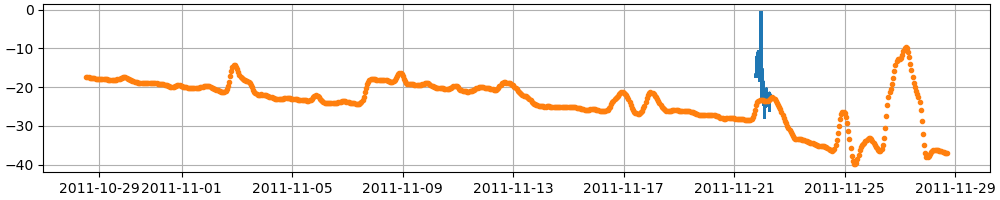

In [17]:
plt.close()
plt.figure(figsize=(10,2), constrained_layout=True)

i=32
plt.plot(dfs.time[dfs.drift==i], dfs.z[dfs.drift==i], '.', ms=0.7);
# plt.plot(yd[drift0==i], -P[drift0==i], '.', ms=0.7)

# plt.plot(dfi.index, dfi.wf, '.', ms=0.7)
plt.plot(bld.time, -bld, '.')
# plt.plot(bld.time[Iequil], -bld[Iequil], '.')

# plt.plot(omega/2/pi, Paa)
# plt.yscale('log')
# plt.xscale('log')

plt.grid(True);


In [ ]:
plt.close()
plt.figure(figsize=(10,2), constrained_layout=True)
# plt.plot((df.time.iloc[:500000]-df.time.iloc[0])/pd.Timedelta('1 hour'), df.wf[:500000], '.', ms=0.7)
plt.plot(dft.yd, 1/dft.LObukhov, 'o-', lw=0.5, ms=2)
plt.plot(dft_mean.yd, 1/dft_mean.LObukhov, 'o-', ms=6)
plt.plot(dft_mean.yd, -dft_mean.wbnet*kappa/(dft_mean.ustar**3), 'o-', ms=6)
plt.grid(True)
plt.ylim(-0.2, 0.2);


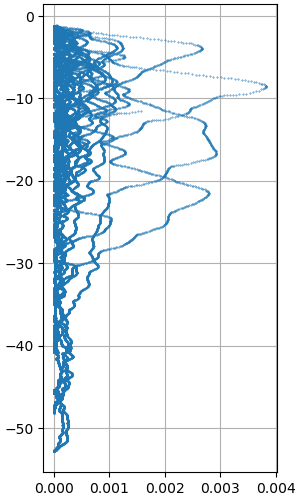

In [33]:
plt.close()
plt.figure(figsize=(3,5), constrained_layout=True)

plt.plot(df.wf2.loc[df.drift==2], df.z.loc[df.drift==2], '.', ms=0.7)
plt.grid(True);

In [38]:
dft_mean = dft.groupby(dft.drift).mean()

In [39]:
dft_mean

<xarray.Dataset>
Dimensions:   (drift: 82)
Coordinates:
  * drift     (drift) float64 2.0 3.0 4.0 5.0 6.0 ... 109.0 110.0 111.0 112.0
Data variables:
    yd        (drift) float64 41.08 42.31 43.31 44.31 ... 139.3 140.3 141.3
    z         (drift) float64 -21.69 -25.16 -28.99 ... -11.78 -15.63 -11.48
    w         (drift) float64 -1.587e-05 -1.132e-05 ... -1.424e-05 4.317e-06
    wf        (drift) float64 -0.0001258 2.113e-05 ... -2.755e-05 -1.211e-05
    epsbulk   (drift) float64 4.47e-07 4.942e-07 ... 1.868e-07 5.048e-07
    ustar     (drift) float64 0.01173 0.01196 0.01743 ... 0.01063 0.009647
    wbnet     (drift) float64 -4.037e-08 -3.763e-09 ... -2.917e-08 -2.772e-08
    bld       (drift) float64 68.93 62.53 70.4 73.52 ... 27.83 35.42 34.27 43.03
    lat       (drift) float64 50.03 50.0 49.98 49.94 ... 50.01 50.06 50.09 50.12
    lon       (drift) float64 -145.0 -144.9 -144.9 ... -144.2 -144.2 -144.2
    LObukhov  (drift) float64 156.6 63.21 -292.6 -88.91 ... 176.4 28.78 -140.3

In [ ]:
plt.close()
plt.figure(figsize=(8,2), constrained_layout=True)

# plt.plot(ydP[idf], Zc[idf], '.',ms=1)
# plt.plot(ydP[idf][tmp], Zc[idf][tmp], 'o',ms=3, fillstyle='none');
plt.plot(dft.drift, dft.epsbulk, '.-',ms=2)
plt.yscale('log');

In [94]:
# average data in 1hr-1m bin
dftb = bin_w(dfs, year)
dftb['ustar2'] = ustar.interp(time=dftb.time, method='nearest')**2
dftb['wstar2'] = wstar.interp(time=dftb.time, method='nearest')**2
dftb['wbulk'] = wbulk.interp(time=dftb.time, method='nearest')
dftb['LObukhov'] = LObukhov.interp(time=dftb.time, method='nearest')
dftb['zeta'] = np.abs(dftb.mz)/dftb.LObukhov
dftb['bld'] = bld.interp(time=dftb.time, method='nearest')
dftb['zoh'] = dftb.mz/dftb.bld
dftb['wf2our2'] = dftb.wf2/dftb.ustar2
dftb['wf2owr2'] = dftb.wf2/dftb.wstar2

# timescale for BLD variation
dbld_dt = bld.differentiate('time', datetime_unit='h')
Tbld = (bld/np.abs(dbld_dt)).interp(time=dftb.time, method='nearest') # [hr]
# timescale for overturning
Tot = (2*bld/wbulk/3600).interp(time=dftb.time, method='nearest') # [hr]
DOF = 10
# categorize boundary layer stationarity 
dftb['Iequil'] = Tbld > DOF*Tot
dftb['Ishoal'] = (Tbld <= DOF*Tot) & (dbld_dt.interp(time=dftb.time, method='nearest') < 0)
dftb['Ideepen'] = (Tbld <= DOF*Tot) & (dbld_dt.interp(time=dftb.time, method='nearest') > 0)

# # mixing layer depth from pressure
# hmix = sot.get_hmix(yd, -z, ustar, wbnet)
# attrs={'description': 'Processed drift data from the Lagrangian float deployed in '+str(year)+' near ocean climate station Papa'})

In [95]:
dftb

<xarray.Dataset>
Dimensions:   (time: 1445, z: 105)
Coordinates:
  * time      (time) datetime64[ns] 2011-02-09T18:02:37.884209 ... 2011-05-21...
  * z         (z) float64 -104.5 -103.5 -102.5 -101.5 ... -3.5 -2.5 -1.5 -0.5
    yd        (time) float64 40.75 40.79 40.84 40.88 ... 141.5 141.6 141.6 141.7
Data variables: (12/21)
    drift     (time) float64 2.0 2.0 2.0 2.0 2.0 ... 112.0 112.0 112.0 112.0
    mz        (time, z) float64 nan nan nan nan ... -3.641 -2.425 -1.354 -0.9869
    w         (time, z) float64 nan nan nan nan ... 0.0034 -1.541e-05 0.01737
    wf        (time, z) float64 nan nan nan nan ... 0.004413 -0.001006 -0.002119
    wf2       (time, z) float64 nan nan nan ... 0.0003078 8.861e-05 4.489e-06
    wf2bulk   (time) float64 0.000159 0.000159 0.000159 ... 0.0001486 0.0001486
    ...        ...
    zoh       (time, z) float64 nan nan nan nan ... -0.05621 -0.03138 -0.02288
    wf2our2   (time, z) float64 nan nan nan nan ... 0.8218 3.367 0.9693 0.0491
    wf2owr2   (time, z) float64 nan nan nan nan ... 0.7802 3.197 0.9202 0.04662
    Iequil    (time) bool True True True True True ... True True True True True
    Ishoal    (time) bool False False False False ... False False False False
    Ideepen   (time) bool False False False False ... False False False False

In [3]:
nc_name = 'LKWA_drifts_'+str(floatID)+'.nc'
dft.to_netcdf(nbf_dir + nc_name, engine='netcdf4')
print(f'Processed float drift data: {nc_name} saved at {nbf_dir}.\n')

nc_name = 'LKWA_drifts_binned_'+str(floatID)+'.nc'
dftb.to_netcdf(nbf_dir + nc_name, engine='netcdf4')
print(f'Binned float drift data: {nc_name} saved at {nbf_dir}.\n')

Compute w for each drift:   0%|          | 0/38 [00:00<?, ?it/s]